# Задача

Создать рекомендательную систему для пользователей библиотеки с учетом семантики

# Условия задачи

Участникам необходимо для каждого из 16 753 пользователей сделать
подборку из 20 рекомендаций.

Порядок рекомендаций не учитывается, но
очень важно, чтобы рекомендации основывались на интересе пользователя
и были ему релевантны. Обратите внимание, что тестирующая система
принимает только те решения, в которых содержится не более 20
рекомендаций для одного пользователя. Уникальных документов – 354 355.

Участники получают 3 таблицы: users.csv, items.csv,
train_transactions.csv.

Users.csv содержит информацию о читателях, где каждый читатель имеет свой
уникальный номер читательского билета (chb).

Таблица items.csv, содержит описание документов, которые доступны всем читателям,
каждый документ имеет уникальный системный номер (sys_numb).

Таблица train_transactions.csv устанавливает связь между
users-items, показывает наличие взаимодействия читателя с документом.

# Описание данных

##### users.csv:
chb – полный номер читательского билета
age – возраст читателя
gender – пол читателя
chit_type – тип читателя

##### items.csv:
sys_numb – системный номер документа
title – название документа
author – автор документа
izd – издательство
year_izd – год издания
bbk – ББК документа

##### train_transactions.csv:
chb - полный номер читательского билета
sys_numb – системный номер документа
date_1 – дата выдачи
is_real – был ли выдан заказ
type – тип книговыдачи (книговыдача/скачивание)
source – источник (один из трёх онлайн-просмотрщиков)
is_printed – печатный/электронный документ


Загрузим необходимые библиотеки

In [1]:
import re

import numpy as np
import pandas as pd

import roman

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from yellowbrick.cluster import KElbowVisualizer

import torch
import transformers

import faiss

from tqdm.notebook import tqdm

In [2]:
tokenizer = transformers.BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational')
model = transformers.BertModel.from_pretrained('DeepPavlov/rubert-base-cased-conversational').to('cuda:0')

try:
	items_title_embeddings = pd.read_csv('items_title_embeddings.csv')
except:
	pass

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Шаг 1. Загрузим и посмотрим на данные

In [4]:
users = pd.read_csv(
	'../data/users.csv',
	sep=';',
	index_col=None,
	dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str}
)

items = pd.read_csv(
	'../data/items.csv',
	sep=';',
	index_col=None,
	dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str}
)

train_transactions = pd.read_csv(
	'../data/train_transactions_extended.csv',
	sep=';',
	index_col=None,
	dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str}
)

users.name = 'users'
items.name = 'items'
train_transactions.name = 'train_transactions'

all_data = [users, items, train_transactions]

Руками заполним пропуски в некоторых данных

In [5]:
# у пользователя с индексом 9681 в данных полях стоит значение "отсутствует", заменим его на самое частотное значение поля
users.loc[9681, 'gender'] = users['gender'].value_counts().index[0]
users.loc[9681, 'age'] = users['age'].value_counts().index[0]
users.loc[9681, 'chit_type'] = users['chit_type'].value_counts().index[0]
users.loc[8978, 'age'] = users['age'].value_counts()[0]

# книга без заполненных данных, ее некому будет рекомендовать
items.loc[45417, 'year_izd'] = '2016'
# заполним пропуски в поле bbk
items['bbk'] = items['bbk'].fillna('отсутствует')

# поля "none" и "отсутствует" по сути одно и то же, так что заменим none на отсутствует
items['title'] = items['title'].apply(lambda author: 'отсутствует' if 'none' in author else author)
items['author'] = items['author'].apply(lambda author: 'отсутствует' if 'none' in author else author)
items['izd'] = items['izd'].apply(lambda author: 'отсутствует' if 'none' in author else author)
items['year_izd'] = items['year_izd'].apply(lambda author: 'отсутствует' if 'none' in author else author)
items['bbk'] = items['bbk'].apply(lambda author: 'отсутствует' if 'none' in author else author)

# удаляем квадратные скобки из годов
items['year_izd'].apply(lambda year: year.replace('[', '').replace(']', '')).value_counts()

# создаем фичу определяющую является ли кника учебником или нет
items['is_textboot'] = items['title'].apply(lambda title: int(max([x in title for x in ['учеб', 'Учеб']])))

# типы "скачивание" и "скачка" одинаковые, приводим к единому виду "скачивание"
train_transactions['type'] = train_transactions['type'].apply(lambda type: 'скачивание' if 'скачка' in type else type)

Немного магии с годом издания книги

In [6]:
def is_roman_number(year):
	if '۱۱۴۵' in year:
		return 'отсутствует'

	pattern = r'\d{4}|[I|V|X|L|C|D|M]+'
	res = re.findall(pattern, year)
	if len(res) > 0:
		if len(res) > 1:
			return res[1]
		else:
			return res[0]
	else:
		pattern = r'[а-я]|[А-Я]|[a-z]|[A-Z]'
		res = re.findall(pattern, year)
		if len(res) > 0:
			return 'отсутствует'
		else:
			return year

def from_roman_to_int(year):
	try:
		return str(roman.fromRoman(year))
	except:
		return year

def validate(year):
	try:
		if int(year) >= 2022 or int(year) <= 1000:
			return 'отсутствует'
		else:
			return year
	except:
		return year


def parse(year):
	try:
		return year.split(' ')[0]
	except:
		return year


items['year_izd'] = (items['year_izd']
					.apply(is_roman_number)
					.apply(from_roman_to_int)
					.apply(
						lambda year: year
						.replace('?', '')
						.replace('.', '', 2)
						.replace('-', '0', 2)
						.replace('-', '')
						.replace('[', '')
						.replace(']', '')
					)
					.apply(parse)
					.apply(validate)
					.apply(
						lambda year: year
						.replace('.', '0')
						.replace('–', '0')
						)
					)

Приводим в порядок информацию об издательстве

In [7]:
def check_izdat(izdat):
	if '[б. и.]' in izdat:
		return 'отсутствует'
	elif 'Б. и.' in izdat:
		return 'отсутствует'
	return izdat.replace('[', '').replace(']', '')

items['izd'] = items['izd'].apply(check_izdat)

Приводим в порядок информацию об авторах (увеличивает число дублей среди авторов на 1132 (было 181734, стало 182866)

In [8]:
def get_only_author(author):
	pattern = r'\D+'
	return ' '.join(re.findall(pattern, author)).replace(',', '').replace('-', '')

items['author'] = items['author'].apply(get_only_author)

Создадим таблицу с данными, какие клиенты какие книги уже брали, чтобы их не рекомендовать

In [9]:
books_readed_by_clients = train_transactions.groupby('chb')['sys_numb'].apply(set)

In [10]:
for data in all_data:
	print(f'{"="*30}{data.name}{"="*30}')
	display(data.sample(7))

==============================users==============================


chb age  gender   chit_type
2063   300000995494  52  female  нет данных
1112   200001135312  21    male  нет данных
13464  300000951039  23  female  нет данных
7241   200000973561  24  female  нет данных
13836  300001085965  19    male  нет данных
12137  300000947116  67    male  нет данных
10850  200001057982  19  female        echb

==============================items==============================


sys_numb                                              title  \
232430  RSL01001850097                                       Живая книга    
135084  RSL01008782515  Функции языка в культуре транзитивного периода...   
329412  RSL01000583581  Государственная кадровая политика и механизм е...   
135441  RSL01003307459  Особенности невербального взаимодействия интер...   
229271  RSL01007137664  Воины стальных магистралей : Краткий воен.-ист...   
353024  RSL01001060830               Дикорастущие травы Якутии в культуре   
7900    RSL01011004836  Сравнительный анализ концепций толкования прав...   

                               author           izd     year_izd  \
232430  Марченко Евдокия Дмитриевна          РАДАТС         2002   
135084         Дрофа Светлана Юрьевна   отсутствует         2016   
329412                    отсутствует   Изд-во РАГС         1998   
135441    Матовская Анна Владимировна   отсутствует         2006   
229271    Терехин Константин Петрович     Воениздат         1969   
353024                    отсутствует  Сиб. отд-ние         1981   
7900        Белова Марина Анатольевна   отсутствует  отсутствует   

                                bbk  is_textboot  
232430                  отсутствует            0  
135084                  отсутствует            0  
329412  Х627я73-2\nУ9(2)240-18я73-2            0  
135441                    С556.57,0            0  
229271                  отсутствует            0  
353024                  отсутствует            0  
7900                    отсутствует            0

==============================train_transactions==============================


chb        sys_numb      date_1 is_real         type  \
116029  200001056136  RSL01003280493  2021-04-12     yes   скачивание   
118334  200001061264  RSL01004404643  2021-03-25     yes         None   
85705   200000939050  RSL01002632958  2021-01-22     yes  книговыдача   
79250   200000916822  RSL01003392555  2022-01-15     yes  книговыдача   
153972  300000796263  RSL01010247474  2021-06-10     yes  книговыдача   
185504  300000933517  RSL01003261634  2021-02-21     yes   скачивание   
249218  300001110567  RSL01005571302  2021-06-15     yes   скачивание   

             source is_printed  
116029  dlib.rsl.ru      False  
118334         None       True  
85705    2DL.Viewer      False  
79250    2DL.Viewer      False  
153972   2DL.Viewer      False  
185504  dlib.rsl.ru      False  
249218  dlib.rsl.ru      False

In [281]:
print(f"Кол-во пользователей: {len(train_transactions['chb'].unique())}")
print(f"Кол-во документов в истории пользователей: {len(train_transactions['sys_numb'].unique())}")
print(f"Общее кол-во документов: {len(items['sys_numb'].unique())}")

Кол-во пользователей: 16753
Кол-во документов в истории пользователей: 194666
Общее кол-во документов: 354355


In [11]:
fig = px.histogram(
	title='Распределение пользователей по гендеру',
	x=users['gender'].value_counts(normalize=True).index,
	y=users['gender'].value_counts(normalize=True)
)

fig.update_xaxes(
	title='Пол'
)

fig.update_yaxes(
	title='%'
)

fig.show()

## Подготовим признаки в таблицах

In [12]:
users_data_encoder = OrdinalEncoder()
users_encode_columns = ['gender', 'chit_type']
users[users_encode_columns] = users_data_encoder.fit_transform(users[users_encode_columns])
users.head()

chb age  gender  chit_type
0  300001020830  21     0.0        2.0
1  300001113642  36     0.0        2.0
2  300001148466  46     0.0        2.0
3  300001117011  22     0.0        2.0
4  200001038094  24     0.0        0.0

In [13]:
users['age'] = users['age'].astype('int')

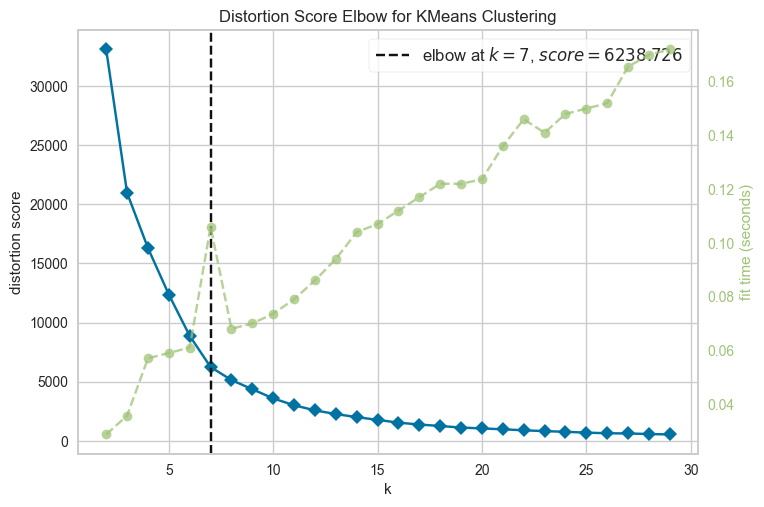

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [309]:
# scaler = StandardScaler()
# kmean = KMeans()
# visualiser = KElbowVisualizer(kmean, k=(2, 30))
# visualiser.fit(scaler.fit_transform(users[['age', 'gender', 'chit_type']]))
# visualiser.show()

In [14]:
kmean_pipe = make_pipeline(
	StandardScaler(),
	KMeans(n_clusters=6)
)
users['user_kmean_class'] = kmean_pipe.fit_predict(users[['age', 'gender', 'chit_type']])
users.sample(7)

chb  age  gender  chit_type  user_kmean_class
12159  200001067293   20     0.0        2.0                 0
10002  200000954508   21     0.0        2.0                 0
2579   200000782184   24     0.0        0.0                 4
13743  200000996286   26     0.0        2.0                 0
291    300001106627   25     0.0        2.0                 0
6416   300000836787   31     0.0        2.0                 0
15006  200000986984   18     1.0        2.0                 5

In [15]:
items_data_encoder = OrdinalEncoder()
items_encode_columns = ['author', 'izd', 'bbk']
items[items_encode_columns] = items_data_encoder.fit_transform(items[items_encode_columns])
items.sample(7)

sys_numb                                              title  \
62957   RSL01004082497  Устав родильнаго приюта в г. Киеве в память чу...   
343965  RSL01005907896  Экспансия американского империализма на Ближне...   
199289  RSL01008862097  Медицинская, микробиология, вирусология и имму...   
344270  RSL01000095056  Разработка методических основ по организационн...   
44150   RSL01003845233  Постановления Переяславского уездного земского...   
9293    RSL01002281969  Туристский рынок : Исследование, моделирование...   
26415   RSL01008827354  История создания Транссибирской железнодорожно...   

          author      izd year_izd       bbk  is_textboot  
62957   123263.0  28410.0     1904  130777.0            0  
343965  129048.0   7389.0     1955  130777.0            0  
199289  171478.0  33897.0     2017  130777.0            1  
344270  119763.0  33897.0     1997   62125.0            0  
44150   112446.0  33897.0     1904  130777.0            0  
9293    158093.0  33897.0     2001  130777.0            0  
26415    20447.0  33897.0     1972   41926.0            0

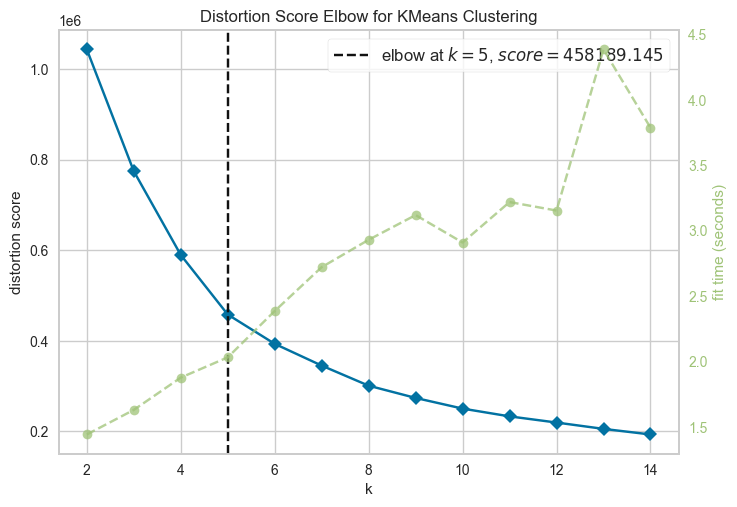

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [310]:
# visualiser = KElbowVisualizer(kmean, k=(2, 15))
# visualiser.fit(scaler.fit_transform(items[items_encode_columns + ['is_textboot']]))
# visualiser.show()

In [16]:
kmean_pipe = make_pipeline(
	StandardScaler(),
	KMeans(n_clusters=5)
)

items['item_kmean_class'] = kmean_pipe.fit_predict(items[['author', 'izd', 'bbk', 'is_textboot']])
items.sample(7)

sys_numb                                              title  \
126089  RSL01002439988   Историческая этнология : учеб. пособие для вузов   
237939  RSL01004150330                  Старение и гены = Aging and genes   
253757  RSL01005285020  Гражданский процесс : Учебник для обл. и краев...   
255539  RSL01002847041  Интерьер и оборудование гостиниц и ресторанов ...   
182567  RSL01000600953                        История европейского права    
72655   RSL07000464445                                        отсутствует   
101183  RSL01003781793  Правительствующий сенат : (Господа сенат) : 22...   

          author      izd     year_izd       bbk  is_textboot  \
126089   87461.0   2813.0         2004   53527.0            1   
237939   99454.0  19844.0         2008    6914.0            0   
253757   67751.0  26397.0         1935  130777.0            1   
255539   29947.0  18827.0         2005   19546.0            1   
182567    7798.0  19844.0         1999   66633.0            0   
72655   171478.0  33897.0  отсутствует  130777.0            0   
101183  100716.0  26031.0         1911  130777.0            0   

        item_kmean_class  
126089                 1  
237939                 0  
253757                 1  
255539                 1  
182567                 4  
72655                  2  
101183                 2

## Создание эмбеддингов названий книг

In [327]:
# print(f'Максимальная длинна токена: {items["title"].apply(lambda row: row.split()).apply(len).sort_values(ascending=False).values[0]}')

Максимальная длинна токена: 151


Сгенерим эмбеддинги описаний

In [332]:
# batch_size = 1
#
# vector = items['title'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=151))
# # применим padding к векторам
# n = len(max(vector, key=len))
# # англ. вектор с отступами
# padded = np.array([i + [0]*(n - len(i)) for i in vector.values])
#
# # создадим маску для важных токенов
# attention_mask = np.where(padded != 0, 1, 0)
#
# embeddings = []
# for i in tqdm(range(padded.shape[0] // batch_size)):
# 	# преобразуем данные
# 	batch = torch.LongTensor(padded[batch_size*i : batch_size*(i+1)]).to('cuda:0')
# 	# преобразуем маску
# 	attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i : batch_size*(i+1)]).to('cuda:0')
# 	with torch.no_grad():
# 		batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#
# 	# преобразуем элементы методом numpy() к типу numpy.array
# 	embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
#
# features = pd.DataFrame(np.concatenate(embeddings))

  0%|          | 0/354355 [00:00<?, ?it/s]

In [333]:
# features.to_csv('items_title_embeddings.csv', index=False)

In [17]:
items = items.drop('title', axis=1)
items = pd.concat(
	[
		items,
		items_title_embeddings
	],
	axis=1
)
items.sample(7)

sys_numb    author      izd year_izd       bbk  is_textboot  \
186481  RSL01008002192  157571.0   8207.0     2015  102208.0            0   
178518  RSL01007166126  107686.0  30303.0     1970  130777.0            0   
190789  RSL01008124157   72587.0  30273.0     2016   27072.0            0   
263112  RSL01004407069   94110.0  20331.0     2009  127226.0            0   
260208  RSL01002887907   70303.0  21153.0     2006   85055.0            0   
289337  RSL01010773724  171478.0  20447.0     2021  120087.0            0   
171231  RSL01010183910  171478.0  23087.0     2020   68415.0            1   

        item_kmean_class         0         1         2  ...       758  \
186481                 3 -1.432712 -0.034335 -0.236345  ...  0.297557   
178518                 2 -0.740821  0.330114 -0.214346  ... -0.304415   
190789                 0 -1.059329 -0.175170 -0.176869  ...  0.126655   
263112                 4  0.191660  0.569300 -0.905060  ... -0.026362   
260208                 4 -0.404666 -0.401145  0.371096  ...  0.790211   
289337                 2 -0.297270  0.900821 -0.662490  ...  0.128638   
171231                 1 -0.868986 -0.214282  0.166922  ...  0.146619   

             759       760       761       762       763       764       765  \
186481 -0.051491 -0.689205 -0.156564  0.928545 -0.178869 -0.098073 -0.718635   
178518  0.233517 -0.936585 -0.798743 -0.299347 -0.264449 -0.235569 -0.208960   
190789  0.060289 -0.609512  0.110017  0.159000 -0.353034  0.531926 -0.489744   
263112  0.359312 -1.634851 -0.756921  0.345238 -0.252156  0.185625 -0.425610   
260208 -0.063254 -0.526223 -0.355833 -1.205643 -0.107344  0.336233  0.157776   
289337  0.461025 -0.901827 -0.452495  0.646663 -0.667092  0.074225 -1.065891   
171231  0.885643 -1.873930 -1.203728  1.340151  0.165397 -0.325838 -0.688068   

             766       767  
186481  1.089004 -1.012123  
178518 -0.247404 -0.705873  
190789  0.862480 -1.229803  
263112  0.466971 -0.753357  
260208  0.174252 -1.473642  
289337  0.587701 -1.582867  
171231  0.866650 -0.829577  

[7 rows x 775 columns]

In [27]:
train_transactions = train_transactions.drop('date_1', axis=1)

transactions_data_encoder = OrdinalEncoder()
transactions_encode_columns = ['is_real', 'type', 'source', 'is_printed']
train_transactions[transactions_encode_columns] = transactions_data_encoder.fit_transform(train_transactions[transactions_encode_columns])
train_transactions.sample(7)

chb        sys_numb  is_real  type  source  is_printed
24901   100000989759  RSL01000222255      1.0   1.0     0.0         0.0
84027   200000929864  RSL01010523898      1.0   0.0     1.0         1.0
230179  300001065973  RSL01010811623      1.0   0.0     1.0         1.0
66631   200000872413  RSL01008773874      1.0   1.0     0.0         0.0
30636   100001039693  RSL01008960356      1.0   2.0     2.0         0.0
90877   200000964724  RSL01005294096      1.0   1.0     0.0         0.0
27005   100001010750  RSL01002919372      1.0   1.0     0.0         0.0

## Объединим датасеты


In [19]:
for data in all_data:
	display(data.head())

chb  age  gender  chit_type  user_kmean_class
0  300001020830   21     0.0        2.0                 0
1  300001113642   36     0.0        2.0                 0
2  300001148466   46     0.0        2.0                 2
3  300001117011   22     0.0        2.0                 0
4  200001038094   24     0.0        0.0                 4

sys_numb                                              title  \
0  RSL01008600016  Судебное следствие в уголовном процессе России...   
1  RSL01004304880  Уральское казачество и его роль в системе росс...   
2  RSL07000461043                                        отсутствует   
3  RSL07000433335                                        отсутствует   
4  RSL01002419013  "Я пишу как эхо другого.." : Очерки интеллекту...   

     author      izd     year_izd       bbk  is_textboot  item_kmean_class  
0   93911.0  32580.0         2016   72799.0            0                 0  
1   48327.0  33897.0         2006  130777.0            0                 4  
2  171478.0  33897.0  отсутствует  130777.0            0                 2  
3  171478.0  33897.0  отсутствует  130777.0            0                 2  
4  167650.0  22996.0         2004  122581.0            0                 2

chb        sys_numb      date_1 is_real         type  \
0  100000641403  RSL01004206702  2021-02-21     yes   скачивание   
1  100000641403  RSL01000769304  2021-03-23     yes   скачивание   
2  100000641403  RSL01004211574  2021-02-21     yes   скачивание   
3  100000644359  RSL01009800093  2021-03-16     yes  книговыдача   
4  100000644359  RSL01003557352  2021-03-10     yes  книговыдача   

                source is_printed  
0          dlib.rsl.ru      False  
1          dlib.rsl.ru      False  
2          dlib.rsl.ru      False  
3  единый просмоторщик      False  
4  единый просмоторщик      False

In [153]:
full_data = pd.merge(pd.merge(train_transactions, users, on='chb', how='left'), items, on='sys_numb', how='left')
full_data.loc[full_data[full_data['year_izd'] == ''].index, 'year_izd'] = '0'
full_data['year_izd'] = full_data['year_izd'].apply(lambda year: 0 if 'отсутствует' in year else year).astype('int')
full_data.sample(7)

chb        sys_numb  is_real  type  source  is_printed  age  \
41608   100001112575  RSL01010595229      1.0   0.0     1.0         1.0   53   
120182  200001064395  RSL01009928434      1.0   0.0     1.0         1.0   26   
138798  200001122088  RSL01003729901      1.0   0.0     1.0         1.0   45   
98288   200000997633  RSL01008597155      1.0   0.0     1.0         1.0   28   
66760   200000872413  RSL01010175814      1.0   1.0     0.0         0.0   49   
226323  300001060076  RSL01006568157      1.0   0.0     1.0         1.0   30   
170729  300000888342  RSL01010383793      0.0   0.0     1.0         1.0   47   

        gender  chit_type  user_kmean_class  ...       758       759  \
41608      0.0        2.0                 2  ... -0.182060  0.520894   
120182     0.0        2.0                 0  ... -0.134906  0.751512   
138798     0.0        2.0                 2  ...  0.049814 -0.066478   
98288      0.0        2.0                 0  ... -0.512130  0.202305   
66760      0.0        2.0                 2  ...  0.935424  0.456380   
226323     0.0        0.0                 4  ... -0.002161  0.092448   
170729     0.0        2.0                 2  ...  0.407810  0.523548   

             760       761       762       763       764       765       766  \
41608  -0.657684 -0.714850  0.947420 -0.068864  0.104628 -0.167222  0.428453   
120182 -0.311012 -0.868036  0.141072  0.254368 -0.191114 -1.011764  0.685422   
138798 -0.816386 -0.655694  0.220371 -0.266958 -0.100544 -0.795979  0.979628   
98288  -0.891117 -0.045451  0.219538 -0.010667 -0.259594  0.196747  0.543027   
66760  -1.574409 -1.249104  0.632695  0.733758  0.206539  0.068372  0.952508   
226323 -1.427339 -0.693176  1.555279 -0.525897  0.308880 -1.188840  1.041690   
170729 -1.192696 -0.371286  0.659207  0.300905  0.028364 -0.098118  0.907466   

             767  
41608  -1.707944  
120182 -0.692713  
138798 -1.502995  
98288  -0.052060  
66760  -0.690666  
226323 -0.765705  
170729 -0.398676  

[7 rows x 784 columns]

In [154]:
full_data = full_data.drop_duplicates().reset_index(drop=True)

# Построим индексы

In [156]:
# new_full_data = full_data.set_index(['chb', 'sys_numb'], drop=True).head()
user_full_data = full_data[['chb', 'sys_numb']]
full_data = full_data.drop(['chb', 'sys_numb'], axis=1)

In [157]:
index = faiss.IndexFlatL2(full_data.shape[1])
print(index.ntotal)  # пока индекс пустой

index.add(np.ascontiguousarray(full_data.to_numpy().astype('float32')))
print(index.ntotal)  # теперь в нем n векторов

topn = 10

product_index_in_data = 4732
_, same_embedding_indexes = index.search(
	np.ascontiguousarray(full_data.to_numpy().astype('float32')[product_index_in_data].reshape((1, -1))),
	topn)

print(same_embedding_indexes[0])  # индексы самых похожих векторов
# print(distances)  # расстояния, отсортированные по убыванию

0
232500
[  4732 219396 112718  98986  74308  86515 137942  76514 228466   1695]


In [107]:
user_full_data.loc[0, 'sys_numb']

'RSL01004206702'

In [139]:
full_data

is_real  type  source  is_printed  age  gender  chit_type  \
0           1.0   2.0     2.0         0.0   55     1.0        2.0   
1           1.0   2.0     2.0         0.0   55     1.0        2.0   
2           1.0   2.0     2.0         0.0   55     1.0        2.0   
3           1.0   1.0     3.0         0.0   74     1.0        2.0   
4           1.0   1.0     3.0         0.0   74     1.0        2.0   
...         ...   ...     ...         ...  ...     ...        ...   
259561      1.0   2.0     3.0         0.0   24     0.0        2.0   
259562      1.0   1.0     3.0         0.0   24     0.0        2.0   
259563      1.0   1.0     0.0         0.0   57     0.0        1.0   
259564      1.0   1.0     0.0         0.0   57     0.0        1.0   
259565      1.0   1.0     0.0         0.0   57     0.0        1.0   

        user_kmean_class    author      izd  ...       758       759  \
0                      1   90012.0   6678.0  ...  0.065123  0.166407   
1                      1  162326.0  33897.0  ...  0.110751 -0.201146   
2                      1   90012.0  17263.0  ...  0.089830  1.259667   
3                      1    4695.0  33897.0  ...  0.717945  0.204790   
4                      1   59405.0  34398.0  ...  0.194303  0.801021   
...                  ...       ...      ...  ...       ...       ...   
259561                 0   39226.0  33897.0  ...  0.121779 -0.007060   
259562                 0   39226.0  33897.0  ...  0.121779 -0.007060   
259563                 2   55095.0  33897.0  ...  0.210080  0.670301   
259564                 2  166725.0  33897.0  ...  0.410351  0.667557   
259565                 2  161353.0  33897.0  ...  0.529365  0.574900   

             760       761       762       763       764       765       766  \
0      -0.929062 -1.570717  1.182836  0.154705 -0.059341 -0.554070  1.136342   
1      -0.490864 -0.417093  0.660165  0.363387  0.335909 -0.025728  0.621890   
2      -1.342462 -0.622515 -0.784814 -0.653788  0.197984 -0.752029  0.107121   
3      -1.340435 -0.866478  0.673882  0.489811  0.158450 -0.399002  0.644413   
4      -2.640173 -0.631588  0.470963 -0.473628 -0.663802 -0.181864  0.855526   
...          ...       ...       ...       ...       ...       ...       ...   
259561 -1.090299 -1.226669  0.640793 -0.061827 -0.053529 -0.179711  0.985212   
259562 -1.090299 -1.226669  0.640793 -0.061827 -0.053529 -0.179711  0.985212   
259563 -0.946697 -1.221898  0.880380  0.135779  0.340078 -0.230168  0.619887   
259564 -0.928046 -1.270568  0.899249  0.400051  0.649324 -0.438847  1.200948   
259565 -1.219546 -1.267168  1.008405  0.577522  0.568613 -0.232914  0.888987   

             767  
0      -0.938955  
1      -0.834285  
2      -0.618580  
3      -0.857777  
4       0.276205  
...          ...  
259561 -0.660092  
259562 -0.660092  
259563 -0.613586  
259564 -0.554233  
259565 -0.952379  

[232500 rows x 782 columns]

In [158]:
# сохраняем индекс в файл
faiss.write_index(index, 'faiss_product_usage_index.index')

In [194]:
def get_recommendation():
	res = []
	n_rec = 100
	for chb in tqdm(set(users.chb.values)):
		count_rec = 0
		# получаем множество уже прочитанных книг
		readed = books_readed_by_clients[str(chb)]
		user_index = min(user_full_data[user_full_data['chb'] == chb].index)
		# формируем рекомендации
		_, same_embedding_indexes = index.search(
			np.ascontiguousarray(full_data.to_numpy().astype('float32')[user_index].reshape((1, -1))),
			n_rec
		)
		# для каждой рекомендации
		for same_index in same_embedding_indexes[0]:
			# проверяем нет ли ее в уже прочитанных
			# если нет, то добавляем в результат
			# если есть, то переходим к следующей рекомендации
			# print(same_index)
			item = user_full_data.loc[same_index, 'sys_numb']
			if item not in list(readed):
				count_rec += 1
				res.append([chb, item])
			if count_rec == 20:
				break
	return res

In [195]:
pd.DataFrame(get_recommendation(), columns=['chb', 'sys_numb']).to_csv('res.csv', index=False)

  0%|          | 0/16753 [00:00<?, ?it/s]

In [182]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0, n_iter=1000, metric='cosine')
embeddings2d = tsne.fit_transform(full_data.iloc[:15000, :])
# Create DF
embeddingsdf = pd.DataFrame()
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]

C:\ProgramData\Anaconda3\envs\digital_breakthrough\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\ProgramData\Anaconda3\envs\digital_breakthrough\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [183]:
px.scatter(
	x=embeddingsdf['x'],
	y=embeddingsdf['y']
).show()